## **Project Report**


### **Introduction**


This report describes a system built to detect and classify multiple geometric shapes (circles, squares, triangles) in synthetic images, each shape colored in red, green, or blue. Specifically, the goal is to:
- Predict their type and color.
- Scale easily to new shapes or colors without modifying the architecture.

To address these goals, we use a two-step approach:
- Faster R-CNN for bounding-box detection (locating each shape).
- A label embedding–based CNN that classifies both the shape and color.

Unlike a single hardcoded output layer (a fixed nine-class output), our embedding-based CNN separates shape and color classification into two flexible heads. Each head stores learnable embeddings for every shape or color label, making it easy to add more shapes or colors by simply extending the embedding matrix. This design scales seamlessly when new object types are introduced, requiring only dataset and embedding updates rather than fundamental architecture changes.



### **Challenge Considerations**

- No Direct Localization Labels: Since the CSV does not provide bounding boxes, any spatial information about shapes must be extracted at inference time. Our approach, discussed later, leverages a bounding-box detector (Faster R-CNN) to address this gap.

- Multi-Label Classification: Each image can contain multiple shapes, each of which has a color. Our system must correctly identify all shape-color combinations.

- Scalability: The dataset currently includes three shapes and three colors, but one core requirement is that the final architecture should scale seamlessly to new or additional shape and color classes (e.g., pentagon, yellow).

### **Data**

The dataset for this task comprises:
- Image Files: Each image contains at least one and up to a configurable maximum number of shapes (circles, squares, or triangles), each rendered in one of three colors (red, blue, green).
- Annotations CSV: For each image, the CSV provides:
    - image_path: The filepath to the corresponding .png file.
    - label: A Python-style list of (shape, color) tuples describing which shapes appear, e.g., [("square", "blue"), ("circle", "red")].

While the dataset is largely non-overlapping by design, a subset of images exhibits shapes that nearly or very subtly overlap. Specifically, these images carry IDs in:                                                         


{'40', '1655', '3145', '1168', '286', '148', '2652', 
 '2321', '3331', '3533', '3716', '4408', '4883', '4965'}


Because tight overlaps could cause ambiguity in shape boundaries, these images were excluded from training and evaluation. This exclusion helps maintain a cleaner scenario for shape detection and classification.

### **Approach Overview**

Our solution uses a **two-stage pipeline** to detect and classify shapes, addressing the fact that the dataset provides only lists of `(shape, color)`—no bounding boxes. The process involves:

1. **Faster R-CNN for Bounding Box Detection**  
   - **Rationale**: We needed a robust, multi-object detector that could handle multiple shapes in a single image without explicit bounding-box labels. Faster R-CNN’s proposal mechanism suits moderate datasets (e.g., ~5K images) and easily accommodates new shape classes by adjusting its final layer.  
   - We used HSV thresholding and contour approximation to generate bounding boxes for each `(shape, color)` described in the CSV. These bounding boxes, though approximate, were sufficient to fine-tune a COCO-pretrained Faster R-CNN for localizing shapes (triangle, square, circle).

2. **Label Embedding–Based CNN for Shape & Color**  
   - Rather than treat every `(shape, color)` combination as a single class (which would lock us into a fixed 3×3 setup), we built a CNN that has two learned embedding heads—one for shapes and one for colors. This design allows adding new shapes or colors without hardcoded output sizes.  
   - At inference, each bounding box proposed by Faster R-CNN is cropped, resized, and passed into this CNN, which independently predicts the shape and color by producing separate logits for each category.

3. **End-to-End Pipeline**  
   - The final system first **detects** shapes with Faster R-CNN, then **classifies** each detected region’s shape and color with the embedding-based CNN, outputting a set of `(shape, color)` pairs per image. This two-stage structure offers both **scalability** (easy extension to new classes) and **robustness** (Faster R-CNN’s proven detection capabilities), neatly resolving the lack of direct bounding-box annotations in the original data.


### Implementation

**Faster R-CNN Fine-Tuning**

- **Pretrained Model:**  
  We initialized `fasterrcnn_resnet50_fpn(pretrained=True)` from PyTorch, which is trained on COCO.

- **Modified Head:**  
  The original COCO classification head was replaced with a `FastRCNNPredictor` matching our shape classes plus one background class.

- **Training Setup:**  
  - Trained for two epochs on our synthetic dataset.
  - Used Adam with a small learning rate (e.g., 0.0005).
  - Ground-truth bounding boxes were derived from HSV-based contour detection.

**Shape & Color Classification**

- **Network Architecture:**

   In the EmbeddingCNN model, instead of using a fixed-size linear layer (e.g., nn.Linear(64, 3) for shapes or colors), each label (shape or color) is represented by a learnable embedding vector. After the CNN produces a feature vector for a given image or patch, the similarity (dot product) with each label embedding becomes the logit for that label. This way, you don’t hardcode how many shapes or colors exist: adding new ones simply means adding rows to the embedding matrices (one for shapes, one for colors), without changing the architecture itself.

  
  We built a CNN feature extractor consisting of three convolutional layers with ReLU activations and max-pooling that flattens into a 64-dimensional vector. Two embedding-based heads then produce separate logits:
  - **Shape Head:**  
    Maps the feature vector to `num_shapes` logits (e.g., triangle, square, circle) using a learned embedding matrix.
  - **Color Head:**  
    Maps the feature vector to `num_colors` logits (e.g., red, green, blue) via its own learned embedding matrix.

- **Training Procedure:**  
  - Patches were cropped from the detected bounding-box regions and resized (e.g., 75×75).
  - We treated shape and color classification as two distinct tasks, each with its own categorical label. By computing one cross-entropy loss for shape and another for color, we ensure that the network optimizes accuracy on both tasks simultaneously. Summing these losses means the model balances learning shape distinctions (triangle vs. square vs. circle) and color distinctions (red vs. blue vs. green), rather than prioritizing one over the other. This approach also maintains the flexibility of handling new shapes or colors without forcing them into a single combined output layer.
  - Typically, seven epochs of training sufficed for good convergence.


![Alt Text](./architecture.png)


### **Model Performance Analysis**

The model was trained over 7 epochs

**Training Analytics**

**Loss Trends**

- **Train Loss:**  
  Rapidly decreased from **0.5448** (Epoch 1) to **0.0003** (Epoch 7), indicating strong convergence.

- **Validation Loss:**  
  Similarly dropped from **0.2364** to **0.0002**, showing no signs of overfitting. The alignment between training and validation loss suggests robust generalization.

- **Anomaly:**  
  A slight spike in training loss at Epoch 5 (**0.0197**) and validation loss (**0.0035**) may indicate transient instability, possibly due to noisy samples, learning rate adjustments, or parameter updates.


![Alt Text](./train_val.jpeg)


**Task-Specific Performance**

**Color Classification**
- **Performance:** Achieved perfect scores (Accuracy, F1, Jaccard = 1.0) from Epoch 1 onward.
- The task is likely trivial for the model, suggesting the dataset’s color features are highly separable or the model prioritizes color learning early.

**Shape Classification**
- **Rapid Improvement:** Accuracy/F1 improved from approximately 0.96 (Epoch 1) to 1.0 (Epoch 3 onward).
- **Jaccard Index:** Increased from 0.9194 (Epoch 1) to 1.0, indicating near-perfect segmentation/classification overlap.
- **Critical Point:** By Epoch 3, the model achieved saturation, implying diminishing returns for additional training.


![Alt Text](./f_score.jpeg)


![Alt Text](./jaccard.jpeg)


**Evaluation Metrics and Interpretation**

**Consistency Across Metrics**
For both tasks, **Accuracy**, **F1**, and **Jaccard** scores align perfectly (e.g., 1.0 in later epochs). This suggests a lack of class imbalance or ambiguity in the validation set.

> **Potential Concern**: Perfect scores may indicate an oversimplified validation set. Further testing on harder edge cases need to be checked.

**Generalization**
Validation metrics mirror training metrics (e.g., *Epoch 7: Train Loss = 0.0003 vs. Val Loss = 0.0002*), confirming the model’s reliability on unseen data.


## Insights and Observations

**Rapid Convergence**
- The network’s loss dropped significantly within the first two or three epochs (e.g., from 0.54 to 0.0047 in just three epochs), and the validation metrics approached near-perfection by the 3rd epoch.
- This quick convergence suggests high contrast, consistent coloring, and little variation in background, allowing the model to learn shape and color features very efficiently.

**Minor Fluctuation at Epoch 5**
- A small spike in training loss occurred at epoch 5 (0.0008 → 0.0197), accompanied by a slight but negligible dip in shape accuracy (from 100% down to ~99.92%). Transient increases like this can happen when the optimizer explores new parameter regions. Because validation performance remained extremely high, it did not indicate overfitting or instability—just a normal oscillation as the network continued to refine its weights.

**Stable Plateau**
- After epoch 5, both training and validation losses fell back to minimal levels (almost zero), and classification metrics returned to 100%.
- The network effectively plateaued by epoch 6, achieving perfect (or near-perfect) performance for both shape and color classification.
- This plateau suggests the model fully captured the relevant features.

**Checkpoint Selection**
- Given the sustained perfect metrics after epoch 3, any of the final epochs could serve as the final checkpoint.
- In practice, the epoch 7 checkpoint was used for inference, ensuring that the small fluctuation observed at epoch 5 was well past and the model was thoroughly converged.

**Synthetic Data Observations**
- Because the dataset comprises synthetic images with clear shapes and colors, the classification task is relatively straightforward, leading to extremely high accuracy.
- In a more complex real-world scenario (with noise, lighting changes, occlusion, etc.), we might see a slower convergence or less-than-perfect metrics.

**Overall:**  
The evaluation results confirm the effectiveness of the two-stage approach (bounding box detection + embedding-based classification) on these synthetic images. Despite the minor transient loss increase at epoch 5, the final model rapidly regained near-perfect performance, illustrating both the stability of the training process and the relative simplicity of the dataset.


### **Key Takeaways**


- The model achieved near-perfect performance by Epoch 3, raising questions about whether 7 epochs were necessary. Early stopping at Epoch 3–4 could save computational resources.

- The model demonstrates exceptional performance on both tasks, likely due to well-separated features and task simplicity.

- Training stability and alignment between training/validation metrics suggest a well-regularized architecture.

### **Possible Improvement**

Although the current two-step solution (**Faster R-CNN** for detection followed by an **embedding-based CNN** for shape/color classification) is effective, one potential enhancement would be to develop a **single unified model**. Such a model could directly process raw images and produce predictions in the desired CSV format without requiring explicit bounding-box generation or post-processing steps. In practice, this might involve:

- **End-to-End Architecture**: Designing or adapting a multi-task network that learns both localization and classification jointly, thus streamlining the pipeline and potentially reducing inference latency and system complexity.

- **Joint Loss Functions**: Incorporating separate objectives (e.g., bounding-box regression, shape classification, color classification) into a single end-to-end training process could yield better synergy between tasks.

- **Reduced Engineering Overhead**: Eliminating the handover between two models would simplify deployment and maintenance, making the solution more robust and easier to update.

While the current approach is effectively *“end-to-end”* in the sense that it automates shape detection and color classification, moving to a truly unified model would remove the need for a secondary classifier and might further improve performance if the network can leverage all relevant features in a single training loop.


### References

- https://www.youtube.com/watch?v=Xycec1paxOo&t=13s
- https://www.youtube.com/watch?v=PPpKlPYL95c
- https://www.reddit.com/r/deeplearning/comments/1amvyay/multilabel_image_classification_model_wherehow_to/?rdt=35386

### Github Link

- https://github.com/KomK2/multi_label_multi_image.git ( Currently private , but will make public if asked).

### Appendix: Code Implementation


**Label Embedding CNN Architecture**


In [ ]:
import torch
import torch.nn as nn

class LabelEmbeddingHead(nn.Module):
    """
    A flexible 'head' that stores an embedding (dictionary) for each label (shape or color).
    The final logits for each label come from dot products with the CNN feature vector.
    """
    def __init__(self, num_labels: int, embed_dim: int):
        super().__init__()
        # shape: (num_labels, embed_dim)
        self.label_embeddings = nn.Parameter(
            torch.randn(num_labels, embed_dim)  # random init
        )

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """
        features: [batch_size, embed_dim]
        returns:  [batch_size, num_labels]
        We do a matrix multiply of the form (B x E) x (E x L) -> (B x L).
        """
        # Transpose label_embeddings to shape (embed_dim, num_labels)
        return features @ self.label_embeddings.T

class EmbeddingCNN(nn.Module):
    """
    CNN feature extractor + label embedding heads for shapes and colors.
    """
    def __init__(self, num_shapes: int, num_colors: int, embed_dim=64):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))  # final shape: [batch_size, 64, 1, 1]
        )
        self.embed_dim = embed_dim

        self.shape_head = LabelEmbeddingHead(num_shapes, embed_dim)
        self.color_head = LabelEmbeddingHead(num_colors, embed_dim)


    def forward(self, x: torch.Tensor):
        """
        x: [batch_size, 3, H, W]
        returns: (shape_logits, color_logits)
        """
        # 1) Extract CNN feature
        features = self.conv_layers(x)                 # shape: [batch_size, 64, 1, 1]
        features = features.view(features.size(0), -1) # shape: [batch_size, 64]

        # 2) Dot product with the shape and color embeddings
        shape_logits = self.shape_head(features)  # [batch_size, num_shapes]
        color_logits = self.color_head(features)  # [batch_size, num_colors]

        return shape_logits, color_logits


### Dataset class

Image: ('/home/kiran/projects/github/test/all-shapes-and-colors/dataset/train_dataset/img_4739.png',)
Shape labels: []
Color labels: []
Image: ('/home/kiran/projects/github/test/all-shapes-and-colors/dataset/train_dataset/img_607.png',)
Shape labels: [tensor([0])]
Color labels: [tensor([1])]
patch size torch.Size([1, 3, 75, 75])


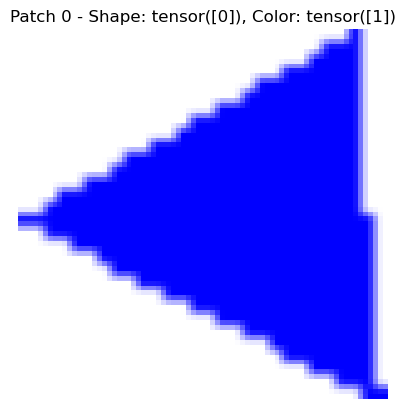

Image: ('/home/kiran/projects/github/test/all-shapes-and-colors/dataset/train_dataset/img_857.png',)
Shape labels: [tensor([1]), tensor([2])]
Color labels: [tensor([2]), tensor([0])]
patch size torch.Size([1, 3, 75, 75])


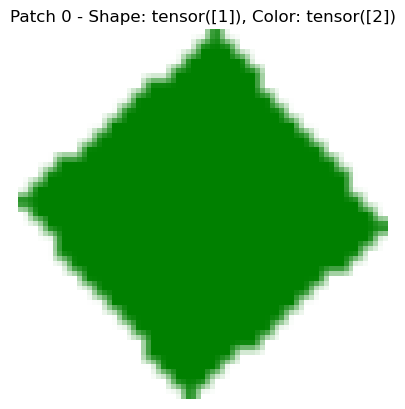

patch size torch.Size([1, 3, 75, 75])


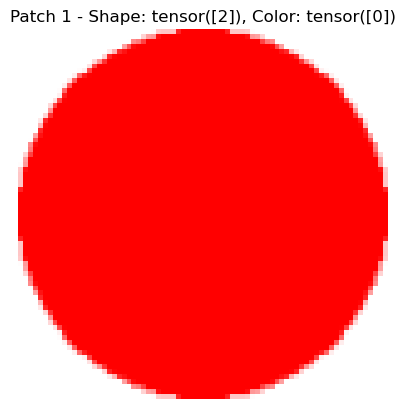

In [21]:
import pandas as pd
import ast
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

class ShapesBoundingBoxDataset(Dataset):
    def __init__(self, csv_file, dataset_dir, transform=None, area_threshold=100, use_matching=False):
        """
        Args:
            csv_file (str): Path to CSV file with columns: image_path, label.
            dataset_dir (str): Directory where the images are stored.
            transform (callable, optional): Transform to apply to each cropped patch.
            area_threshold (int): Minimum area for a contour to be considered a shape.
            use_matching (bool): (Unused in this approach)
        """
        self.df = pd.read_csv(csv_file)
        self.dataset_dir = dataset_dir

        # Exclude specific images by number
        excluded_ids = {'40', '1655', '3145', '1168', '286', '148', '2652', '2321', '3331', '3533', '3716', '4408', '4883', '4965'}
        def is_excluded(image_path):
            filename = os.path.splitext(os.path.basename(image_path))[0]
            if filename.startswith("img_"):
                image_num = filename.split("_")[1]
                return image_num in excluded_ids
            return False
        self.df = self.df[~self.df['image_path'].apply(is_excluded)].reset_index(drop=True)

        transform = transforms.Compose([
            transforms.Resize((75, 75)),
            transforms.ToTensor()
        ])

        self.transform = transform
        self.area_threshold = area_threshold
        self.use_matching = use_matching

        self.color_ranges = {
            'red': ((0, 100, 100), (10, 255, 255)),
            'blue': ((100, 150, 0), (140, 255, 255)),
            'green': ((40, 70, 70), (80, 255, 255))
        }

        self.shapes = ["triangle", "square", "circle"]
        self.colors = ["red", "blue", "green"]
        self.shape2idx = {s: i for i, s in enumerate(self.shapes)}
        self.color2idx = {c: i for i, c in enumerate(self.colors)}

    def detect_shape(self, contour):
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        sides = len(approx)
        if sides == 3:
            return "triangle"
        elif sides == 4:
            return "square"
        else:
            return "circle"

    def find_bounding_boxes(self, hsv, color_name):
        lower, upper = self.color_ranges[color_name]
        mask = cv2.inRange(hsv, lower, upper)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        boxes = []
        for contour in contours:
            if cv2.contourArea(contour) > self.area_threshold:
                shape = self.detect_shape(contour)
                x, y, w, h = cv2.boundingRect(contour)
                boxes.append({
                    'box': (x, y, w, h),
                    'detected_shape': shape,
                    'color': color_name
                })
        return boxes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_img_path = row["image_path"]
        img_path = os.path.join(self.dataset_dir, rel_img_path)

        image_cv = cv2.imread(img_path)
        if image_cv is None:
            raise ValueError(f"Image {img_path} not found")
        hsv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)

        detected_boxes = []
        for color_name in self.color_ranges.keys():
            boxes = self.find_bounding_boxes(hsv, color_name)
            detected_boxes.extend(boxes)

        label_str = row["label"]
        csv_labels = ast.literal_eval(label_str)
        csv_labels = [(s.lower(), c.lower()) for s, c in csv_labels]

        patches = []
        shape_labels = []
        color_labels = []
        for csv_shape, csv_color in csv_labels:
            match_found = False
            for i, box_info in enumerate(detected_boxes):
                if box_info['detected_shape'] == csv_shape and box_info['color'] == csv_color:
                    match_found = True
                    matched_box = detected_boxes.pop(i)
                    x, y, w, h = matched_box['box']
                    patch_cv = image_cv[y:y+h, x:x+w]
                    patch_rgb = cv2.cvtColor(patch_cv, cv2.COLOR_BGR2RGB)
                    patch_pil = Image.fromarray(patch_rgb)
                    if self.transform:
                        patch_pil = self.transform(patch_pil)
                    patches.append(patch_pil)
                    shape_labels.append(self.shape2idx[csv_shape])
                    color_labels.append(self.color2idx[csv_color])
                    break
            if not match_found:
                raise ValueError(f"No matching detection for CSV label {(csv_shape, csv_color)} in image {img_path}")

        return patches, shape_labels, color_labels, img_path

if __name__ == '__main__':
    csv_file = "/home/kiran/projects/github/test/all-shapes-and-colors/train.csv"
    dataset_dir = "/home/kiran/projects/github/test/all-shapes-and-colors/dataset"
    transform = transforms.ToTensor()

    dataset = ShapesBoundingBoxDataset(csv_file, dataset_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    for i, (patches, shape_labels, color_labels, img_path) in enumerate(dataloader):
        print(f"Image: {img_path}")
        print(f"Shape labels: {shape_labels}")
        print(f"Color labels: {color_labels}")

        for j, patch in enumerate(patches):
            print(f"patch size {patch.size()}")
            if isinstance(patch, torch.Tensor):
                patch_np = patch.squeeze(0).permute(1, 2, 0).numpy()
            else:
                patch_np = np.array(patch)
            plt.imshow(patch_np)
            plt.title(f"Patch {j} - Shape: {shape_labels[j]}, Color: {color_labels[j]}")
            plt.axis('off')
            plt.show()

        if i >= 2:
            break


### FastRCNN Dataset Class

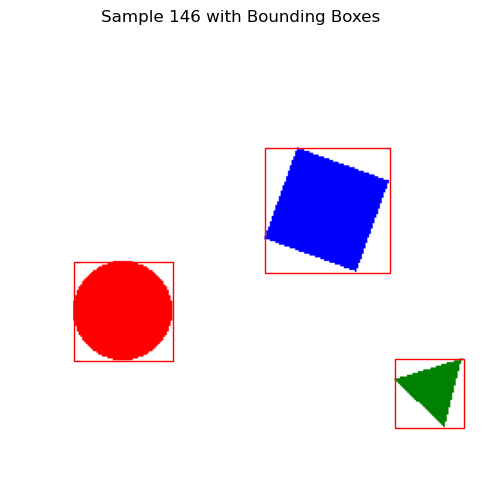

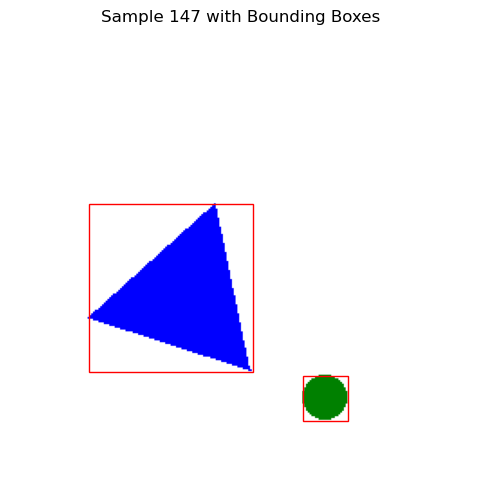

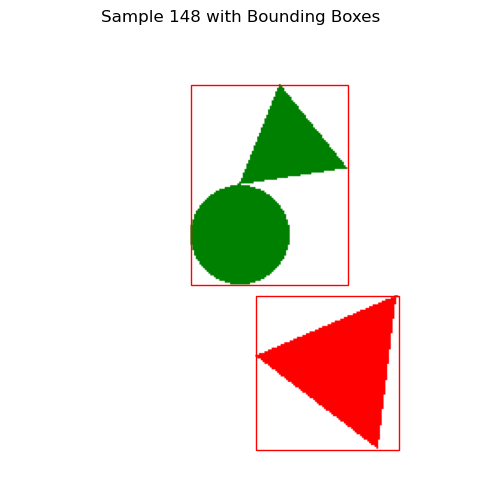

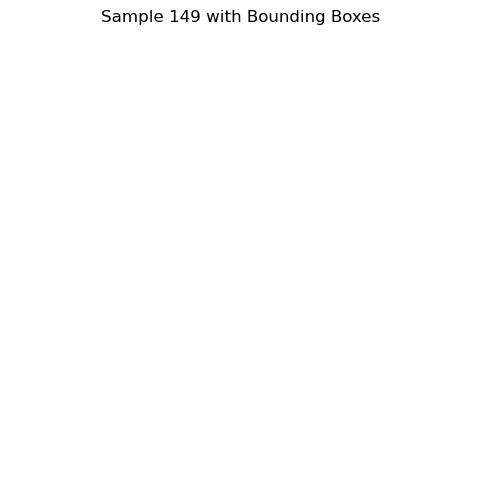

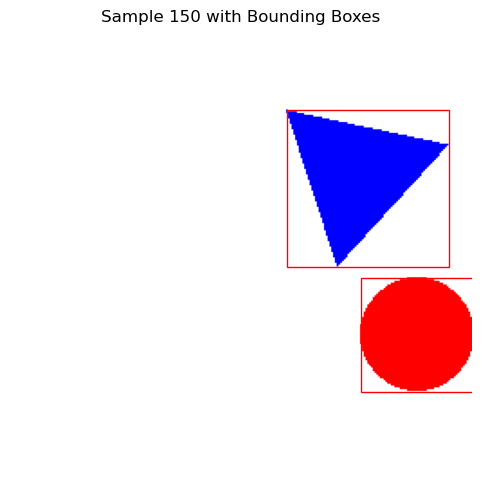

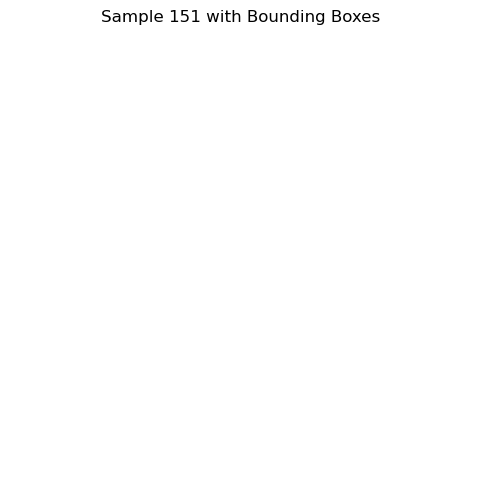

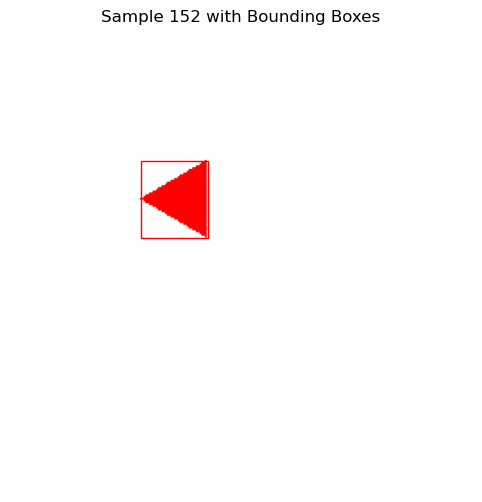

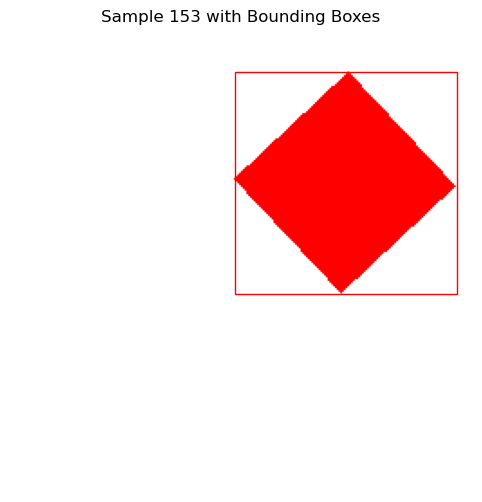

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
import ast
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.patches as patches


class ShapesFRCNNDataset(Dataset):
    def __init__(self, csv_file, dataset_dir, transform=None, area_threshold=100):
        self.df = pd.read_csv(csv_file)
        self.dataset_dir = dataset_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.area_threshold = area_threshold

        self.color_ranges = {
            'red': ((0, 100, 100), (10, 255, 255)),
            'blue': ((100, 150, 0), (140, 255, 255)),
            'green': ((40, 70, 70), (80, 255, 255))
        }

        # Dynamically extract unique shape names
        all_labels = self.df["label"].apply(ast.literal_eval)
        unique_shapes = sorted(list({s.lower() for row in all_labels for s, _ in row}))
        self.shape_to_id = {s: i+1 for i, s in enumerate(unique_shapes)}  # 1-based class IDs

    def __len__(self):
        return len(self.df)

    def detect_shape(self, contour):
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        sides = len(approx)
        if sides == 3:
            return "triangle"
        elif sides == 4:
            return "square"
        else:
            return "circle"

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.dataset_dir, row["image_path"])
        label_str = row["label"]

        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")

        hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
        gt_shape_color = [(s.lower(), c.lower()) for s, c in ast.literal_eval(label_str)]

        boxes, labels = [], []

        for color_name, (lower, upper) in self.color_ranges.items():
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if cv2.contourArea(contour) < self.area_threshold:
                    continue
                detected_shape = self.detect_shape(contour)
                if (detected_shape, color_name) in gt_shape_color:
                    x, y, w, h = cv2.boundingRect(contour)
                    boxes.append([x, y, x+w, y+h])
                    labels.append(self.shape_to_id[detected_shape])

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tensor = self.transform(image_pil)

        return image_tensor, {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64)
        }


if __name__ == '__main__':
    csv_file = "/home/kiran/projects/github/test/all-shapes-and-colors/train.csv"
    dataset_dir = "/home/kiran/projects/github/test/all-shapes-and-colors/dataset"
    transform = transforms.ToTensor()

    dataset = ShapesFRCNNDataset(csv_file=csv_file, dataset_dir=dataset_dir, transform=transform)

    # Loop through a few samples to test dataset usage
    for i in range(146,154):
        image_tensor, target = dataset[i]
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        # Convert image tensor to numpy (H, W, C) for display
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Plot the image and overlay the bounding boxes
        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.imshow(image_np)
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # ax.text(x1, y1 - 5, f"Shape: {label}", color='yellow', fontsize=12, weight='bold')
        ax.set_title(f"Sample {i} with Bounding Boxes")
        ax.axis('off')
        plt.show()

### Faster-RCNN workspace

In [24]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import wandb

from bounding_boxfast_rcnn_dataset import ShapesFRCNNDataset

def collate_fn(batch):
    filtered_batch = [item for item in batch if item[1]["boxes"].numel() > 0]
    if len(filtered_batch) == 0:
        return [], []
    return tuple(zip(*filtered_batch))

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def validate(model, dataloader, device):
    model.eval()
    val_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for images, targets in progress_bar:
            if len(images) == 0:
                continue
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            num_batches += 1
            progress_bar.set_postfix(loss=val_loss/num_batches if num_batches > 0 else 0)
    return val_loss / num_batches if num_batches > 0 else None

def train(model, train_loader, val_loader, device, optimizer, num_epochs, output_dir):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in progress_bar:
            if len(images) == 0:
                continue
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            num_batches += 1
            progress_bar.set_postfix(loss=epoch_loss/num_batches if num_batches > 0 else 0)

        # Save model checkpoint after every epoch
        checkpoint_path = f"{output_dir}/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)

        avg_train_loss = epoch_loss/num_batches if num_batches > 0 else float('inf')
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Run validation and log both train and validation loss to wandb
        val_loss = validate(model, val_loader, device)
        if val_loss is not None:
            print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}")
        wandb.log({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": val_loss})
        


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize wandb for experiment tracking
    wandb.init(project="bounding_box_project")
    
    csv_file = "/home/kiran/projects/github/test/all-shapes-and-colors/train.csv"
    dataset_dir = "/home/kiran/projects/github/test/all-shapes-and-colors/dataset"
    transform = transforms.ToTensor()
    
    dataset = ShapesFRCNNDataset(csv_file, dataset_dir, transform=transform)
    
    # Split dataset: 85% training, 15% validation
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
    
    # Define number of classes (shapes + background)
    num_shapes = len(dataset.shape_to_id)
    num_classes = num_shapes + 1
    
    model = get_model(num_classes)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    num_epochs = 10
    output_dir = "/home/kiran/projects/github/test/bounding_box/outputs"
    
    train(model, train_loader, val_loader, device, optimizer, num_epochs, output_dir)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ksrikiran1 (bmv-lab). Use `wandb login --relogin` to force relogin


/home/kiran/miniconda3/envs/kodiak/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kiran/miniconda3/envs/kodiak/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   2%|█▍                                                                             | 19/1063 [00:08<07:31,  2.31it/s, loss=0.79]


KeyboardInterrupt: 

### CNN (Color + Shape Classifier)

In [ ]:
import torch
from dataset import ShapesBoundingBoxDataset  
from model import DualHeadCNN  
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from label_embedding import EmbeddingCNN

# Custom collate function to handle batches with variable-sized data
def custom_collate(batch):
    # Filter out invalid samples (empty patches)
    valid_samples = [sample for sample in batch if len(sample[0]) > 0]
    
    # If no valid samples, return empty tensors
    if len(valid_samples) == 0:
        empty_patches = torch.empty(0, 3, 75, 75)  
        return empty_patches, torch.tensor([]), torch.tensor([])

    # Aggregate patches, shape labels, and color labels from valid samples
    all_patches = []
    all_shape_labels = []
    all_color_labels = []
    for patches, shape_labels, color_labels, _ in valid_samples:
        all_patches.extend(patches)
        all_shape_labels.extend(shape_labels)
        all_color_labels.extend(color_labels)
    
    # Convert lists to tensors
    all_patches = torch.stack(all_patches)
    all_shape_labels = torch.tensor(all_shape_labels)
    all_color_labels = torch.tensor(all_color_labels)
    
    return all_patches, all_shape_labels, all_color_labels

def main():
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Paths to dataset and CSV file
    csv_file = "/home/kiran/projects/github/test/all-shapes-and-colors/train.csv"
    dataset_dir = "/home/kiran/projects/github/test/all-shapes-and-colors/dataset"
    transform = transforms.ToTensor()  # Transform to convert images to tensors

    # Initialize the dataset
    dataset = ShapesBoundingBoxDataset(csv_file, dataset_dir, transform=transform)

    # Determine the number of shapes and colors from the dataset
    num_shapes = len(dataset.shapes)  # e.g., ["triangle", "square", "circle"]
    num_colors = len(dataset.colors)  # e.g., ["red", "blue", "green"]

    # Create a data loader with the custom collate function
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

    # Initialize the model with dynamic shape and color counts
    model = EmbeddingCNN(num_shapes=num_shapes, num_colors=num_colors, embed_dim=64).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Track total loss for the epoch
        count_samples = 0  # Track the number of processed samples

        for patches, shape_labels, color_labels in dataloader:
            # Skip empty batches
            if patches.size(0) == 0:
                continue

            # Move data to the appropriate device
            patches = patches.to(device)
            shape_labels = shape_labels.to(device)
            color_labels = color_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass through the model
            shape_logits, color_logits = model(patches)

            # Compute losses for shape and color predictions
            loss_shape = criterion(shape_logits, shape_labels)
            loss_color = criterion(color_logits, color_labels)
            loss = loss_shape + loss_color  # Total loss

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate loss and sample count
            epoch_loss += loss.item() * patches.size(0)
            count_samples += patches.size(0)

        # Compute average loss for the epoch
        avg_loss = epoch_loss / count_samples if count_samples > 0 else 0.0
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save the trained model's state
    torch.save(model.state_dict(), "embedding_cnn.pth")

if __name__ == '__main__':
    main()

### Prediction Code (Combining Both the codes):

In [ ]:
# Import necessary libraries
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image

# Import custom modules
from bounding_box.fast_rcnn_dataset import ShapesFRCNNDataset  
from label_embedding import EmbeddingCNN 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from dataset import ShapesBoundingBoxDataset  

# Function to get the Faster R-CNN model with a custom number of classes
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Define paths for training, testing, and dataset directories
train_csv       = "/home/kiran/projects/github/test/all-shapes-and-colors/train.csv"
test_csv        = "/home/kiran/projects/github/test/all-shapes-and-colors/test.csv"
dataset_dir     = "/home/kiran/projects/github/test/all-shapes-and-colors/dataset"

# Define paths for model checkpoints
checkpoint_path = "/home/kiran/projects/github/test/bounding_box/outputs/model_epoch_1.pth"
embedding_cnn_path  = "embedding_cnn.pth"

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the training dataset for Faster R-CNN
train_dataset   = ShapesFRCNNDataset(train_csv, dataset_dir, transform=transforms.ToTensor())
num_shapes      = len(train_dataset.shape_to_id)  # Number of shape classes in detection
num_classes     = num_shapes + 1                  # +1 for background in Faster R-CNN

# Load the detection model and its weights
detection_model = get_model(num_classes)
detection_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
detection_model.to(device)
detection_model.eval()

# Load the dummy dataset for classification
dummy_dataset = ShapesBoundingBoxDataset(csv_file=train_csv, dataset_dir=dataset_dir)
num_shapes_clf = len(dummy_dataset.shapes)  # Number of shape classes for classification
num_colors_clf = len(dummy_dataset.colors)  # Number of color classes for classification

# Load the classification model and its weights
classification_model = EmbeddingCNN(
    num_shapes=num_shapes_clf,
    num_colors=num_colors_clf,
    embed_dim=64
).to(device)
classification_model.load_state_dict(torch.load(embedding_cnn_path, map_location=device))
classification_model.eval()

# Define transformations for detection and classification
detection_transform = transforms.ToTensor()
classification_transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

# Read the test dataset CSV
test_df = pd.read_csv(test_csv)
confidence_threshold = 0.5  # Confidence threshold for detection

# Initialize a list to store predictions
predictions_list = []

# Iterate through each row in the test dataset
for _, row in test_df.iterrows():
    image_rel_path = row["image_path"]  # Get the relative image path
    image_path = os.path.join(dataset_dir, image_rel_path)  # Construct the full image path

    # Load the image and convert it to RGB
    image_pil = Image.open(image_path).convert("RGB")
    image_tensor = detection_transform(image_pil).to(device)

    # Perform object detection
    with torch.no_grad():
        detection_output = detection_model([image_tensor])[0] 
    
    # Extract bounding boxes, scores, and labels
    boxes = detection_output["boxes"].cpu().numpy()
    scores = detection_output["scores"].cpu().numpy()
    labels = detection_output["labels"].cpu().numpy()  
    patches_list = []  # List to store cropped image patches
    box_indices = []   # List to store indices of valid boxes

    # Iterate through detected boxes and filter by confidence threshold
    for i, (box, score) in enumerate(zip(boxes, scores)):
        if score < confidence_threshold:
            continue
        x1, y1, x2, y2 = map(int, box)  # Get box coordinates
        patch_pil = image_pil.crop((x1, y1, x2, y2))  # Crop the image patch
        patch_tensor = classification_transform(patch_pil)  # Apply classification transform
        patches_list.append(patch_tensor)
        box_indices.append(i)

    # If no valid patches, append an empty label and continue
    if not patches_list:
        predictions_list.append({
            "image_path": image_rel_path,
            "label": "[]"
        })
        continue

    # Stack patches into a batch and perform classification
    input_batch = torch.stack(patches_list).to(device)
    with torch.no_grad():
        shape_logits, color_logits = classification_model(input_batch)

        # Get predicted shape and color indices
        shape_preds = torch.argmax(shape_logits, dim=1).cpu().numpy()
        color_preds = torch.argmax(color_logits, dim=1).cpu().numpy()

    # Map indices to shape and color names
    results = []
    for shp_idx, clr_idx in zip(shape_preds, color_preds):
        shp_name = dummy_dataset.shapes[shp_idx]
        clr_name = dummy_dataset.colors[clr_idx]
        results.append((shp_name, clr_name))

    # Remove duplicate predictions
    results = list(set(results))

    # Append predictions to the list
    predictions_list.append({
        "image_path": image_rel_path,
        "label": str(results)
    })

# Create a DataFrame from predictions and save to CSV
submission_df = pd.DataFrame(predictions_list, columns=["image_path", "label"])
submission_df.to_csv("submission_2.csv", index=False)
print("Wrote predictions to submission_2.csv")
